<a href="https://colab.research.google.com/github/Pedro-Ortega-G/P_ESTOCASTICOS/blob/main/gen_biomass_autoe_090325_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno carga desde el ambiente de Colab una base de datos (energy_dataseet.csv) de generación de energia eléctrica de diferentes tipos; de entre los tipos de generación disponibles en la base de datos se seleccionan la serie "generation_biomass" como serie de tiempo a procesar; se le aplica un preprocesamiento rellenando los valores faltantes (interpolación lineal); se seleccionan las primeras 15000 muestras de la serie como sub-set de datos de trabajo; se entrena un autoencoder (ventanas de 400 muestras, dimensión latente de 200 parámertos, 100 épocas, batch de 32 muestras, MinMaxScaler, 80% de datos para entrenamiento y 20% para validación)para reconstruír la señal;
entrena un mlp (StandardScaler, 2 capas densas de 50 neuronas con activación relu) para cada sub-serie (80% de datos para entrenamiento y 20% para validación); se extrae el codificador como modelo separado para obtener las representaciones latentes e ingresarlo como entrada a un mlp (1 capa densa de 200 neuronas con activación relu) que prediga la siguiente muestra.


<ipython-input-13-b23d84d38bdd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 500)                 │          50,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,600 (392.97 KB)

 Trainable params: 100,600 (392.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0884 - val_loss: 0.0062
Epoch 2/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 3/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 4/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 5/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 6/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 7/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 8/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 9/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 11/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 12/100
360/360 ━━━━━━━━━━━━━━━━━━━━

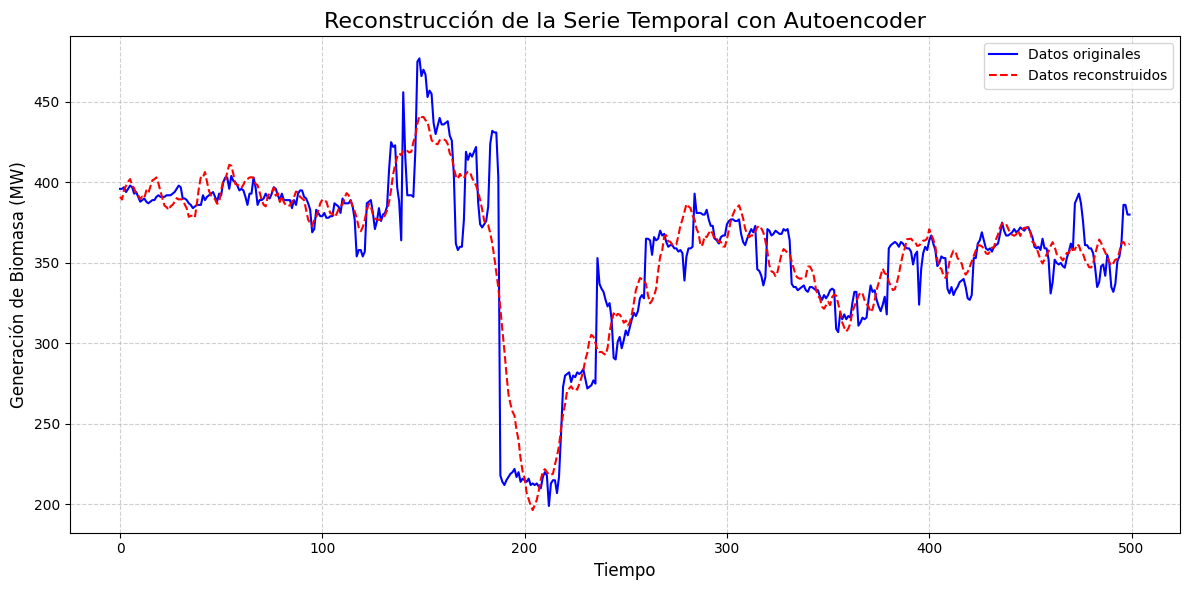

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Cargar el archivo CSV (si no está cargado previamente)
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Seleccionar las primeras 1000 muestras
df_biomass_subset = df_biomass.iloc[:15000]

# Extraer los valores de generación de biomasa como un array NumPy
data = df_biomass_subset["generation biomass"].values.reshape(-1, 1)  # Forma: (1000, 1)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(data_scaled) * 0.8)  # 80% para entrenamiento
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Crear ventanas de tiempo para el autoencoder
def create_windows(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
    return np.array(X)

window_size = 500  # Tamaño de ventana (puedes ajustarlo)
X_train = create_windows(train_data, window_size)
X_test = create_windows(test_data, window_size)

# Definir el modelo de autoencoder
input_dim = window_size  # Entrada: tamaño de la ventana
encoding_dim = window_size//5  # Dimensión latente (capa intermedia)

# Capa de entrada
input_layer = Input(shape=(input_dim,))

# Capa de codificación (compresión)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Capa de decodificación (reconstrucción)
decoded = Dense(input_dim, activation='linear')(encoded)

# Modelo completo del autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Resumen del modelo
autoencoder.summary()

# Entrenar el modelo
history = autoencoder.fit(
    X_train, X_train,  # Entrada y salida son iguales (reconstrucción)
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Evaluar el modelo
test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Pérdida en datos de prueba: {test_loss}")

# Reconstruir los datos de prueba
reconstructed_data = autoencoder.predict(X_test)

# Desescalar los datos originales y reconstruidos
original_data = scaler.inverse_transform(X_test[-1].reshape(1, -1))  # Última ventana de prueba
reconstructed_data_unscaled = scaler.inverse_transform(reconstructed_data[-1].reshape(1, -1))

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(original_data.flatten(), label="Datos originales", color='blue')
plt.plot(reconstructed_data_unscaled.flatten(), label="Datos reconstruidos", color='red', linestyle='--')
plt.title("Reconstrucción de la Serie Temporal con Autoencoder", fontsize=16)
plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-2-d310f9d8819a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │             550 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,060 (4.14 KB)

 Trainable params: 1,060 (4.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3903 - val_loss: 0.2662
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2363 - val_loss: 0.1574
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1283 - val_loss: 0.0896
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0616 - val_loss: 0.0537
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - val_loss: 0.0399
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - val_loss: 0.0347
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - val_loss: 0.0329
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - val_loss: 0.0312
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0301
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0188 - val_loss: 0.0289
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - val_loss: 0.0282
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

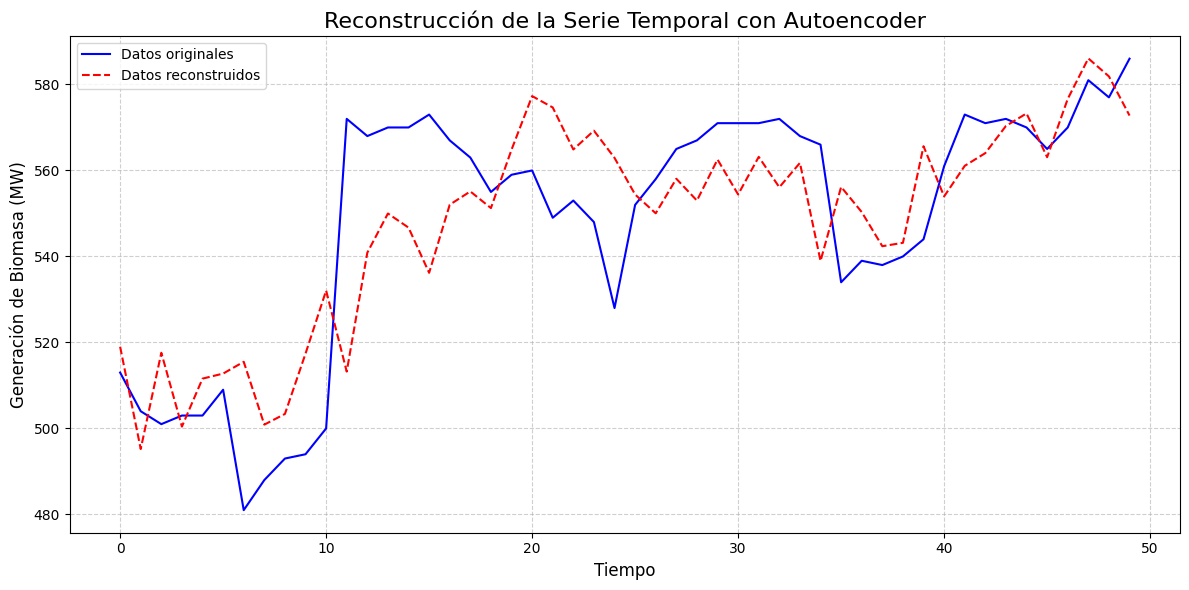

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Seleccionar las primeras 1000 muestras (cambio aquí)
df_biomass_subset = df_biomass.iloc[:1000]  # Reducido de 15000 a 1000

# Extraer los valores de generación de biomasa como un array NumPy
data = df_biomass_subset["generation biomass"].values.reshape(-1, 1)  # Forma: (1000, 1)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(data_scaled) * 0.8)  # 80% para entrenamiento (800 muestras)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]  # 800 y 200

# Crear ventanas de tiempo para el autoencoder
def create_windows(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
    return np.array(X)

window_size = 50  # Reducido de 500 a 50 para adaptarse al tamaño de datos
X_train = create_windows(train_data, window_size)  # 750 ventanas
X_test = create_windows(test_data, window_size)    # 150 ventanas

# Definir el modelo de autoencoder
input_dim = window_size  # Entrada: tamaño de la ventana (50)
encoding_dim = window_size // 5  # Dimensión latente (10)

# Capa de entrada
input_layer = Input(shape=(input_dim,))

# Capa de codificación (compresión)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Capa de decodificación (reconstrucción)
decoded = Dense(input_dim, activation='linear')(encoded)

# Modelo completo del autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Resumen del modelo
autoencoder.summary()

# Entrenar el modelo
history = autoencoder.fit(
    X_train, X_train,  # Entrada y salida son iguales (reconstrucción)
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Evaluar el modelo
test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Pérdida en datos de prueba: {test_loss}")

# Reconstruir los datos de prueba
reconstructed_data = autoencoder.predict(X_test)

# Desescalar los datos originales y reconstruidos
original_data = scaler.inverse_transform(X_test[-1].reshape(1, -1))  # Última ventana de prueba
reconstructed_data_unscaled = scaler.inverse_transform(reconstructed_data[-1].reshape(1, -1))

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(original_data.flatten(), label="Datos originales", color='blue')
plt.plot(reconstructed_data_unscaled.flatten(), label="Datos reconstruidos", color='red', linestyle='--')
plt.title("Reconstrucción de la Serie Temporal con Autoencoder", fontsize=16)
plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-3-7e5709fa67cf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 40)                  │           8,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 200)                 │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,240 (63.44 KB)

 Trainable params: 16,240 (63.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2929 - val_loss: 0.0129
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0106
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

Pérdida en datos de prueba: 0.0012934968108311296
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


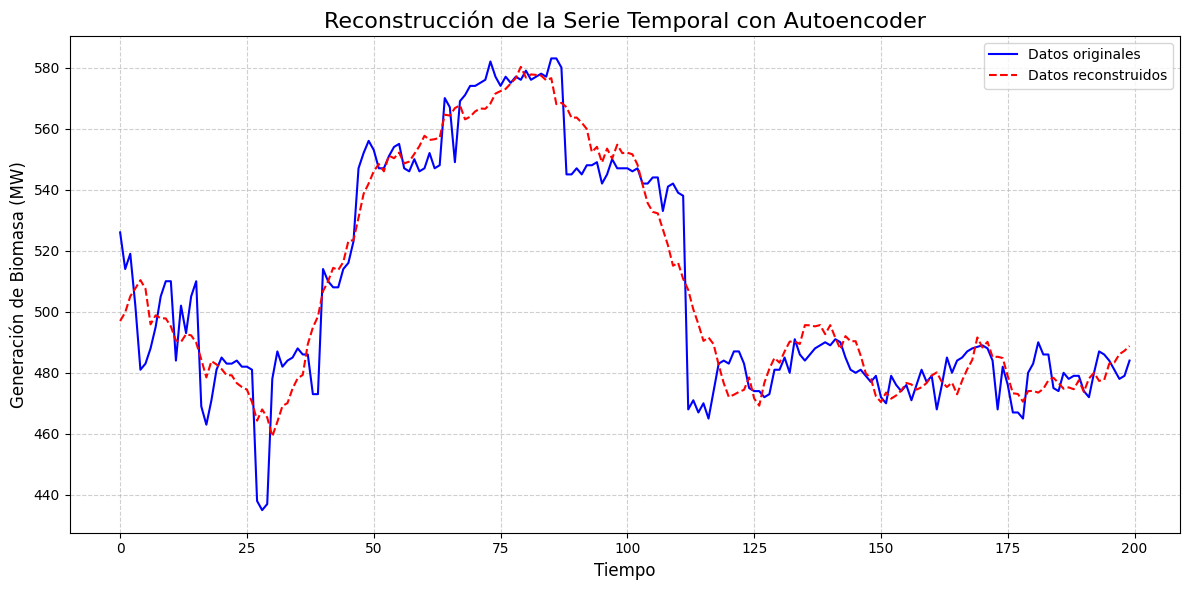

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Seleccionar las primeras 4000 muestras (cambio aquí)
df_biomass_subset = df_biomass.iloc[:4000]  # Reducido de 15000 a 4000

# Extraer los valores de generación de biomasa como un array NumPy
data = df_biomass_subset["generation biomass"].values.reshape(-1, 1)  # Forma: (4000, 1)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(data_scaled) * 0.8)  # 80% para entrenamiento (3200 muestras)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]  # 3200 y 800

# Crear ventanas de tiempo para el autoencoder
def create_windows(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
    return np.array(X)

window_size = 200  # Ajustado de 500 a 200 para adaptarse al tamaño de datos
X_train = create_windows(train_data, window_size)  # 3000 ventanas
X_test = create_windows(test_data, window_size)    # 600 ventanas

# Definir el modelo de autoencoder
input_dim = window_size  # Entrada: tamaño de la ventana (200)
encoding_dim = window_size // 5  # Dimensión latente (40)

# Capa de entrada
input_layer = Input(shape=(input_dim,))

# Capa de codificación (compresión)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Capa de decodificación (reconstrucción)
decoded = Dense(input_dim, activation='linear')(encoded)

# Modelo completo del autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Resumen del modelo
autoencoder.summary()

# Entrenar el modelo
history = autoencoder.fit(
    X_train, X_train,  # Entrada y salida son iguales (reconstrucción)
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Evaluar el modelo
test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Pérdida en datos de prueba: {test_loss}")

# Reconstruir los datos de prueba
reconstructed_data = autoencoder.predict(X_test)

# Desescalar los datos originales y reconstruidos
original_data = scaler.inverse_transform(X_test[-1].reshape(1, -1))  # Última ventana de prueba
reconstructed_data_unscaled = scaler.inverse_transform(reconstructed_data[-1].reshape(1, -1))

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(original_data.flatten(), label="Datos originales", color='blue')
plt.plot(reconstructed_data_unscaled.flatten(), label="Datos reconstruidos", color='red', linestyle='--')
plt.title("Reconstrucción de la Serie Temporal con Autoencoder", fontsize=16)
plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Epoch 1/50


<ipython-input-18-2dcbf5616855>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1662 - val_loss: 0.0148
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0131
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0029


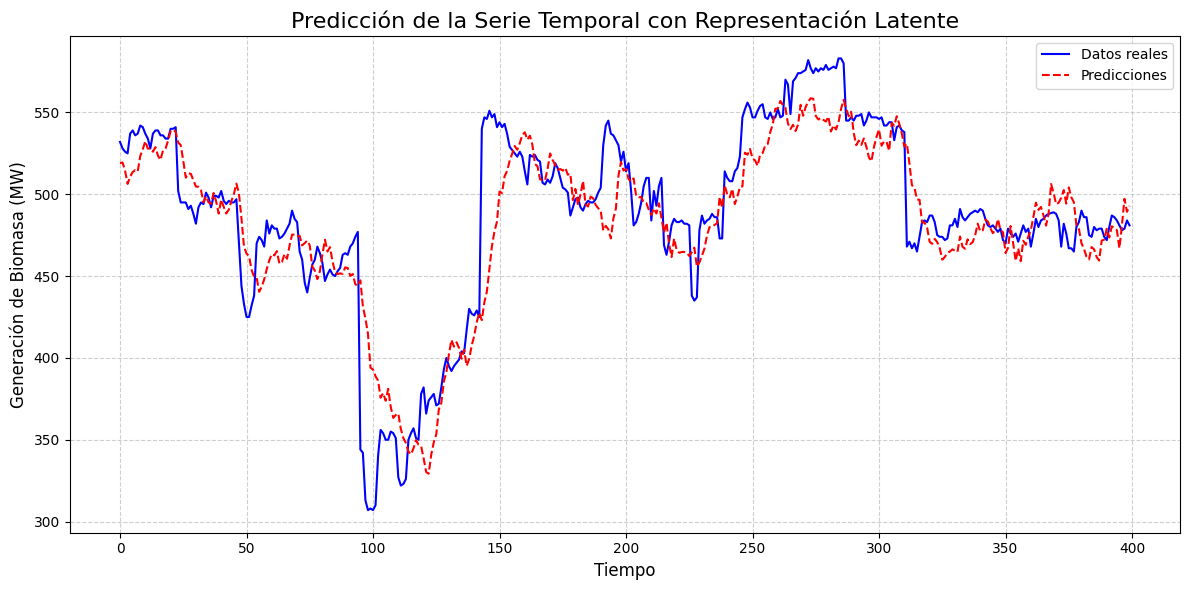

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Seleccionar las primeras 4000 muestras
df_biomass_subset = df_biomass.iloc[:4000]

# Extraer los valores de generación de biomasa como un array NumPy
data = df_biomass_subset["generation biomass"].values.reshape(-1, 1)  # Forma: (4000, 1)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(data_scaled) * 0.8)  # 3200 muestras
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]  # 3200 y 800

# Crear ventanas de tiempo para entrada y salida
def create_windows(data, window_size, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])  # Ventana de entrada
        y.append(data[i + window_size:i + window_size + horizon])  # Valor(es) futuro(s)
    return np.array(X), np.array(y)

window_size = 400  # Tamaño de ventana ajustado
horizon = 1  # Predicción del siguiente punto
X_train, y_train = create_windows(train_data, window_size, horizon)  # 3100 ventanas
X_test, y_test = create_windows(test_data, window_size, horizon)    # 700 ventanas

# Definir el autoencoder
input_dim = window_size  # 100
encoding_dim = window_size // 2  # 20

# Capa de entrada
input_layer = Input(shape=(input_dim,))

# Capa de codificación (compresión)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Capa de decodificación (reconstrucción)
decoded = Dense(input_dim, activation='linear')(encoded)

# Modelo completo del autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Extraer el codificador como modelo separado
encoder = Model(inputs=input_layer, outputs=encoded)

# Entrenar el autoencoder
autoencoder.fit(
    X_train, X_train,
    epochs=50,  # Reducido para enfocarnos en predicción
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Obtener las representaciones latentes
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

# Definir un modelo predictivo basado en la representación latente
predictor_input = Input(shape=(encoding_dim,))
predictor_output = Dense(horizon, activation='linear')(predictor_input)  # Predice 1 valor
predictor = Model(inputs=predictor_input, outputs=predictor_output)
predictor.compile(optimizer='adam', loss='mse')

# Entrenar el modelo predictivo
predictor.fit(
    X_train_latent, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_latent, y_test),
    verbose=1
)

# Hacer predicciones en el conjunto de prueba
y_pred_scaled = predictor.predict(X_test_latent)

# Desescalar las predicciones y los datos reales
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Visualizar los resultados (últimos 100 puntos como ejemplo)
n_points = 1000
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[-n_points:], label="Datos reales", color='blue')
plt.plot(y_pred_unscaled[-n_points:], label="Predicciones", color='red', linestyle='--')
plt.title("Predicción de la Serie Temporal con Representación Latente", fontsize=16)
plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

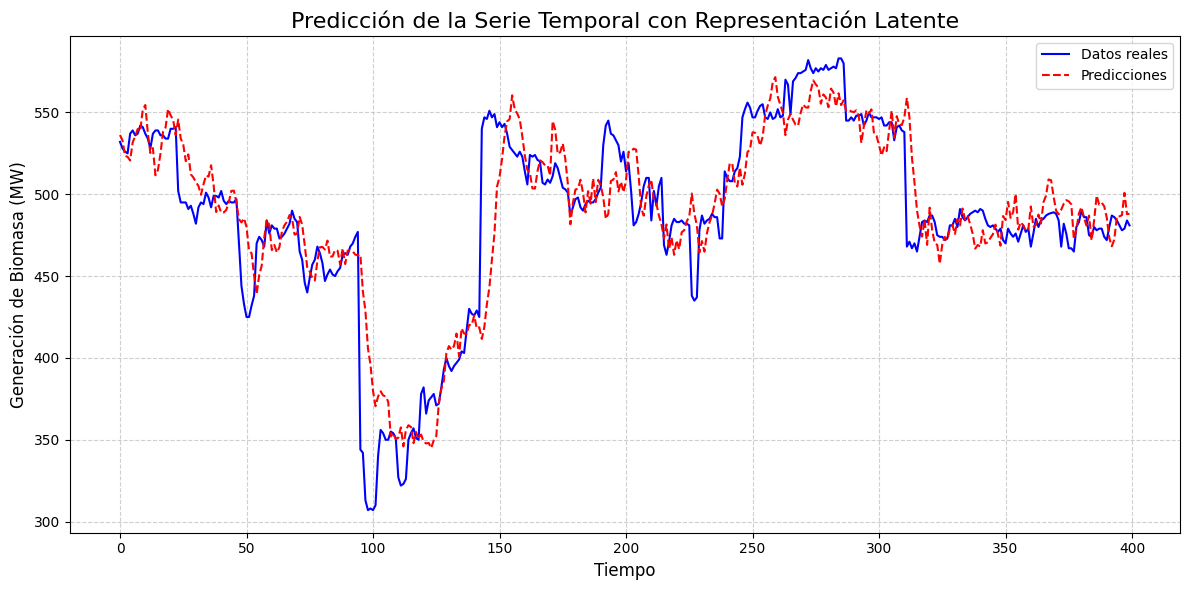

In [ ]:

# Visualizar los resultados (últimos 100 puntos como ejemplo)
n_points = 1000
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[-n_points:], label="Datos reales", color='blue')
plt.plot(y_pred_unscaled[-n_points:], label="Predicciones", color='red', linestyle='--')
plt.title("Predicción de la Serie Temporal con Representación Latente", fontsize=16)
plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Generación de Biomasa (MW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()